In [32]:
from Bio import Phylo
import matplotlib.pyplot as plt
%matplotlib inline
import collections
import matplotlib
import subprocess
import os

plt.rcParams["figure.figsize"] = [12,9]
## Set the default directories for exec and data. 
WORK_DIR="/home/iovercast/manuscript-analysis/"
EMPERICAL_DATA_DIR=os.path.join(WORK_DIR, "example_empirical_rad/")
IPYRAD_DIR=os.path.join(WORK_DIR, "ipyrad/")
PYRAD_EMPIRICAL_OUTPUT=os.path.join(WORK_DIR, "pyrad/REALDATA/")
STACKS_DIR=os.path.join(WORK_DIR, "stacks/")
AFTRRAD_DIR=os.path.join(WORK_DIR, "aftrRAD/")
DDOCENT_DIR=os.path.join(WORK_DIR, "dDocent/")

## Install raxml

In [ ]:
%%bash -s "$WORK_DIR"
## Install raxml
mkdir $1/miniconda/src
cd $1/miniconda/src
git clone https://github.com/stamatak/standard-RAxML.git
cd standard-RAxML
make -f Makefile.PTHREADS.gcc
cp raxml-PTHREADS $1/miniconda/bin

In [60]:
vcf_dict = {}
vcf_dict["ipyrad"] = os.path.join(IPYRAD_DIR, "REALDATA/REALDATA_outfiles/REALDATA-biallelic.recode.vcf")
vcf_dict["pyrad"] = os.path.join(PYRAD_EMPIRICAL_OUTPUT, "outfiles/c85d6m2p3H3N3.vcf")
vcf_dict["stacks_ungapped"] = os.path.join(STACKS_DIR, "REALDATA/ungapped/batch_1.vcf")
vcf_dict["stacks_gapped"] = os.path.join(STACKS_DIR, "REALDATA/gapped/batch_1.vcf")
vcf_dict["stacks_default"] = os.path.join(STACKS_DIR, "REALDATA/default/batch_1.vcf")
vcf_dict["aftrrad"] = os.path.join(AFTRRAD_DIR, "REALDATA/Formatting/REALDATA.vcf")
#vcf_dict["ddocent_full"] = os.path.join(DDOCENT_DIR, "REALDATA/TotalRawSNPs.vcf")
vcf_dict["ddocent_filt"] = os.path.join(DDOCENT_DIR, "REALDATA/Final.snpsonly.recode.vcf")
for k, v in vcf_dict.items():
    if os.path.exists(v):
        print("found - {}".format(v))
    else:
        print("not found - {}".format(v))

found - /home/iovercast/manuscript-analysis/stacks/REALDATA/default/batch_1.vcf
found - /home/iovercast/manuscript-analysis/pyrad/REALDATA/outfiles/c85d6m2p3H3N3.vcf
found - /home/iovercast/manuscript-analysis/aftrRAD/REALDATA/Formatting/REALDATA.vcf
found - /home/iovercast/manuscript-analysis/ipyrad/REALDATA/REALDATA_outfiles/REALDATA-biallelic.recode.vcf
not found - /home/iovercast/manuscript-analysis/stacks/REALDATA/gapped/batch_1.vcf
found - /home/iovercast/manuscript-analysis/dDocent/REALDATA/Final.snpsonly.recode.vcf
found - /home/iovercast/manuscript-analysis/stacks/REALDATA/ungapped/batch_1.vcf


## Make phylip files for all assemblers

In [61]:
## Get this script to convert from vcf to phy
## This script wants python 3, so I had to go in and add the future import for
## print by hand. Add this on line 17:
##
## from __future__ import print_function
##
## Also, had to update lines 32-34 like so:
##
## iupac = {"AG": "R", "CT": "Y", "CG": "S", "AT": "W", "GT": "K", "AC": "M",
##          "CGT": "B", "AGT": "D", "ACT": "H", "ACG": "V", "ACGT": "N", "AA": "A",
##          "CC": "C", "GG": "G", "TT":"T", "GN":"N", "CN":"N", "AN":"N", "TN":"N"}
##          "NT":"N", "NC":"N", "NG":"N", "NA":"N", "NN":"N"}
## Also, the when we decompose the ddocent complex genotypes vcftools splits
## ./. data as '.', which VCF2phy.py kinda hates, so you have to add this piece
## of code on lines 75/75:
##
##    if genotype_string == ".":
##        return "N"
#!wget https://raw.githubusercontent.com/CoBiG2/RAD_Tools/master/VCF2phy.py
ped_raxdir = os.path.join(WORK_DIR, "Pedicularis_raxml")
if not os.path.exists(ped_raxdir):
    os.mkdir(ped_raxdir)
os.chdir(ped_raxdir)

phy_dict = {}
for k, v in vcf_dict.items():
    if os.path.exists(v):
        outphy = v.rsplit("/", 1)[1]
        outphy = os.path.join(ped_raxdir, k + "-" + outphy.rsplit(".", 1)[0])
        print(k, outphy)
        
        cmd = "python VCF2phy.py -vcf {} -o {}".format(v, outphy)
        try:
            ret = subprocess.check_output(cmd, shell=True)
        except:
            print(cmd)
            print("failed - {}".format(k))
        #print(ret)
        phy_dict[k] = outphy

('stacks_default', '/home/iovercast/manuscript-analysis/Pedicularis_raxml/stacks_default-batch_1')
('pyrad', '/home/iovercast/manuscript-analysis/Pedicularis_raxml/pyrad-c85d6m2p3H3N3')
('aftrrad', '/home/iovercast/manuscript-analysis/Pedicularis_raxml/aftrrad-REALDATA')
python VCF2phy.py -vcf /home/iovercast/manuscript-analysis/aftrRAD/REALDATA/Formatting/REALDATA.vcf -o /home/iovercast/manuscript-analysis/Pedicularis_raxml/aftrrad-REALDATA
failed - aftrrad
('ipyrad', '/home/iovercast/manuscript-analysis/Pedicularis_raxml/ipyrad-REALDATA-biallelic.recode')
('ddocent_filt', '/home/iovercast/manuscript-analysis/Pedicularis_raxml/ddocent_filt-Final.snpsonly.recode')
('stacks_ungapped', '/home/iovercast/manuscript-analysis/Pedicularis_raxml/stacks_ungapped-batch_1')


## Run raxml on the phylip files

In [63]:
ped_trees = {}
## Gonna have to hope raxml is smart enough to use the fasta cuz the vcf we get out of 
## aftrrad is broke.
phy_dict["aftrrad"] = "/home/iovercast/manuscript-analysis/aftrRAD/REALDATA/Formatting/SNPMatrix_17.All.fasta"\
for assembler, inputfile in phy_dict.items():
    outdir = ped_raxdir
    ncores = 20
    physplit = 2

    cmd = "{}raxmlHPC-PTHREADS -f a ".format(WORK_DIR + "/miniconda/bin/") \
            + " -T {} ".format(ncores) \
            + " -m GTRGAMMA " \
            + " -N 100 " \
            + " -x 12345 " \
            + " -p 54321 " \
            + " -n {} ".format(assembler) \
            + " -w {} ".format(outdir) \
            + " -s {}".format(inputfile + ".phy")
    print(cmd)
    ## What's the difference?
    ## out_trees[assembler] = "{}/RAxML_bestTree.{}".format(outdir, assembler)
    ped_trees[assembler] = "{}/RAxML_bipartitions.{}".format(outdir, assembler)

    print(assembler)
    #!time $cmd

/home/iovercast/manuscript-analysis//miniconda/bin/raxmlHPC-PTHREADS -f a  -T 20  -m GTRGAMMA  -N 100  -x 12345  -p 54321  -n stacks_default  -w /home/iovercast/manuscript-analysis/Pedicularis_raxml  -s /home/iovercast/manuscript-analysis/Pedicularis_raxml/stacks_default-batch_1.phy
stacks_default
/home/iovercast/manuscript-analysis//miniconda/bin/raxmlHPC-PTHREADS -f a  -T 20  -m GTRGAMMA  -N 100  -x 12345  -p 54321  -n ddocent_filt  -w /home/iovercast/manuscript-analysis/Pedicularis_raxml  -s /home/iovercast/manuscript-analysis/Pedicularis_raxml/ddocent_filt-Final.snpsonly.recode.phy
ddocent_filt
/home/iovercast/manuscript-analysis//miniconda/bin/raxmlHPC-PTHREADS -f a  -T 20  -m GTRGAMMA  -N 100  -x 12345  -p 54321  -n aftrrad  -w /home/iovercast/manuscript-analysis/Pedicularis_raxml  -s /home/iovercast/manuscript-analysis/aftrRAD/REALDATA/Formatting/SNPMatrix_17.All.fasta.phy
aftrrad
/home/iovercast/manuscript-analysis//miniconda/bin/raxmlHPC-PTHREADS -f a  -T 20  -m GTRGAMMA  -N 1

In [68]:
print(ped_trees)

{'stacks_default': '/home/iovercast/manuscript-analysis/Pedicularis_raxml/RAxML_bipartitions.stacks_default', 'pyrad': '/home/iovercast/manuscript-analysis/Pedicularis_raxml/RAxML_bipartitions.pyrad', 'aftrrad': '/home/iovercast/manuscript-analysis/Pedicularis_raxml/RAxML_bipartitions.aftrrad', 'ipyrad': '/home/iovercast/manuscript-analysis/Pedicularis_raxml/RAxML_bipartitions.ipyrad', 'ddocent_filt': '/home/iovercast/manuscript-analysis/Pedicularis_raxml/RAxML_bipartitions.ddocent_filt', 'stacks_ungapped': '/home/iovercast/manuscript-analysis/Pedicularis_raxml/RAxML_bipartitions.stacks_ungapped'}


## Make the pretty colors for each population

In [103]:
## Get sample names and assign them to a species dict
IPYRAD_STATS=os.path.join(IPYRAD_DIR, "REALDATA/REALDATA_outfiles/REALDATA_stats.txt")
infile = open(IPYRAD_STATS).readlines()
sample_names = [x.strip().split()[0] for x in infile[20:33]]
species = set([x.split("_")[1] for x in sample_names])
species_dict = collections.OrderedDict([])

## Ordered dict of sample names and their species, in same order
## as the vcf file
for s in sample_names:
    species_dict[s] = s.split("_")[1]
print(species_dict)

## Map species names to groups of individuals
#for s in species:
#    species_dict[s] = [x for x in sample_names if s in x]
print(species_dict)
species_colors = {
    'rex': '#FF0000',
    'cyathophylla': '#008000',
    'thamno': '#00FFFF',
    'cyathophylloides': '#90EE90',
    'przewalskii': '#FFA500',
    'superba': '#8B0000',
}
emp_colors_per_sample = {}
for name, pop in species_dict.items():
    emp_colors_per_sample[name + "_R1_"] = species_colors[pop]
print(emp_colors_per_sample)

samples_per_species = {}
for s in species:
    samples_per_species[s] = [x + "_R1_" for x in sample_names if s in x]
print(samples_per_species)

OrderedDict([('29154_superba', 'superba'), ('30556_thamno', 'thamno'), ('30686_cyathophylla', 'cyathophylla'), ('32082_przewalskii', 'przewalskii'), ('33413_thamno', 'thamno'), ('33588_przewalskii', 'przewalskii'), ('35236_rex', 'rex'), ('35855_rex', 'rex'), ('38362_rex', 'rex'), ('39618_rex', 'rex'), ('40578_rex', 'rex'), ('41478_cyathophylloides', 'cyathophylloides'), ('41954_cyathophylloides', 'cyathophylloides')])
OrderedDict([('29154_superba', 'superba'), ('30556_thamno', 'thamno'), ('30686_cyathophylla', 'cyathophylla'), ('32082_przewalskii', 'przewalskii'), ('33413_thamno', 'thamno'), ('33588_przewalskii', 'przewalskii'), ('35236_rex', 'rex'), ('35855_rex', 'rex'), ('38362_rex', 'rex'), ('39618_rex', 'rex'), ('40578_rex', 'rex'), ('41478_cyathophylloides', 'cyathophylloides'), ('41954_cyathophylloides', 'cyathophylloides')])
{'30556_thamno_R1_': '#00FFFF', '33588_przewalskii_R1_': '#FFA500', '38362_rex_R1_': '#FF0000', '33413_thamno_R1_': '#00FFFF', '35236_rex_R1_': '#FF0000', '

## Plot the trees

('stacks_default', <matplotlib.axes._subplots.AxesSubplot object at 0x2aaaef214a10>)
('pyrad', <matplotlib.axes._subplots.AxesSubplot object at 0x2aaaef2ea850>)
('aftrrad', <matplotlib.axes._subplots.AxesSubplot object at 0x2aaaef4a6cd0>)
('ipyrad', <matplotlib.axes._subplots.AxesSubplot object at 0x2aaaef4ced10>)
('ddocent_filt', <matplotlib.axes._subplots.AxesSubplot object at 0x2aaaef35b1d0>)
('stacks_ungapped', <matplotlib.axes._subplots.AxesSubplot object at 0x2aaaef0d2110>)


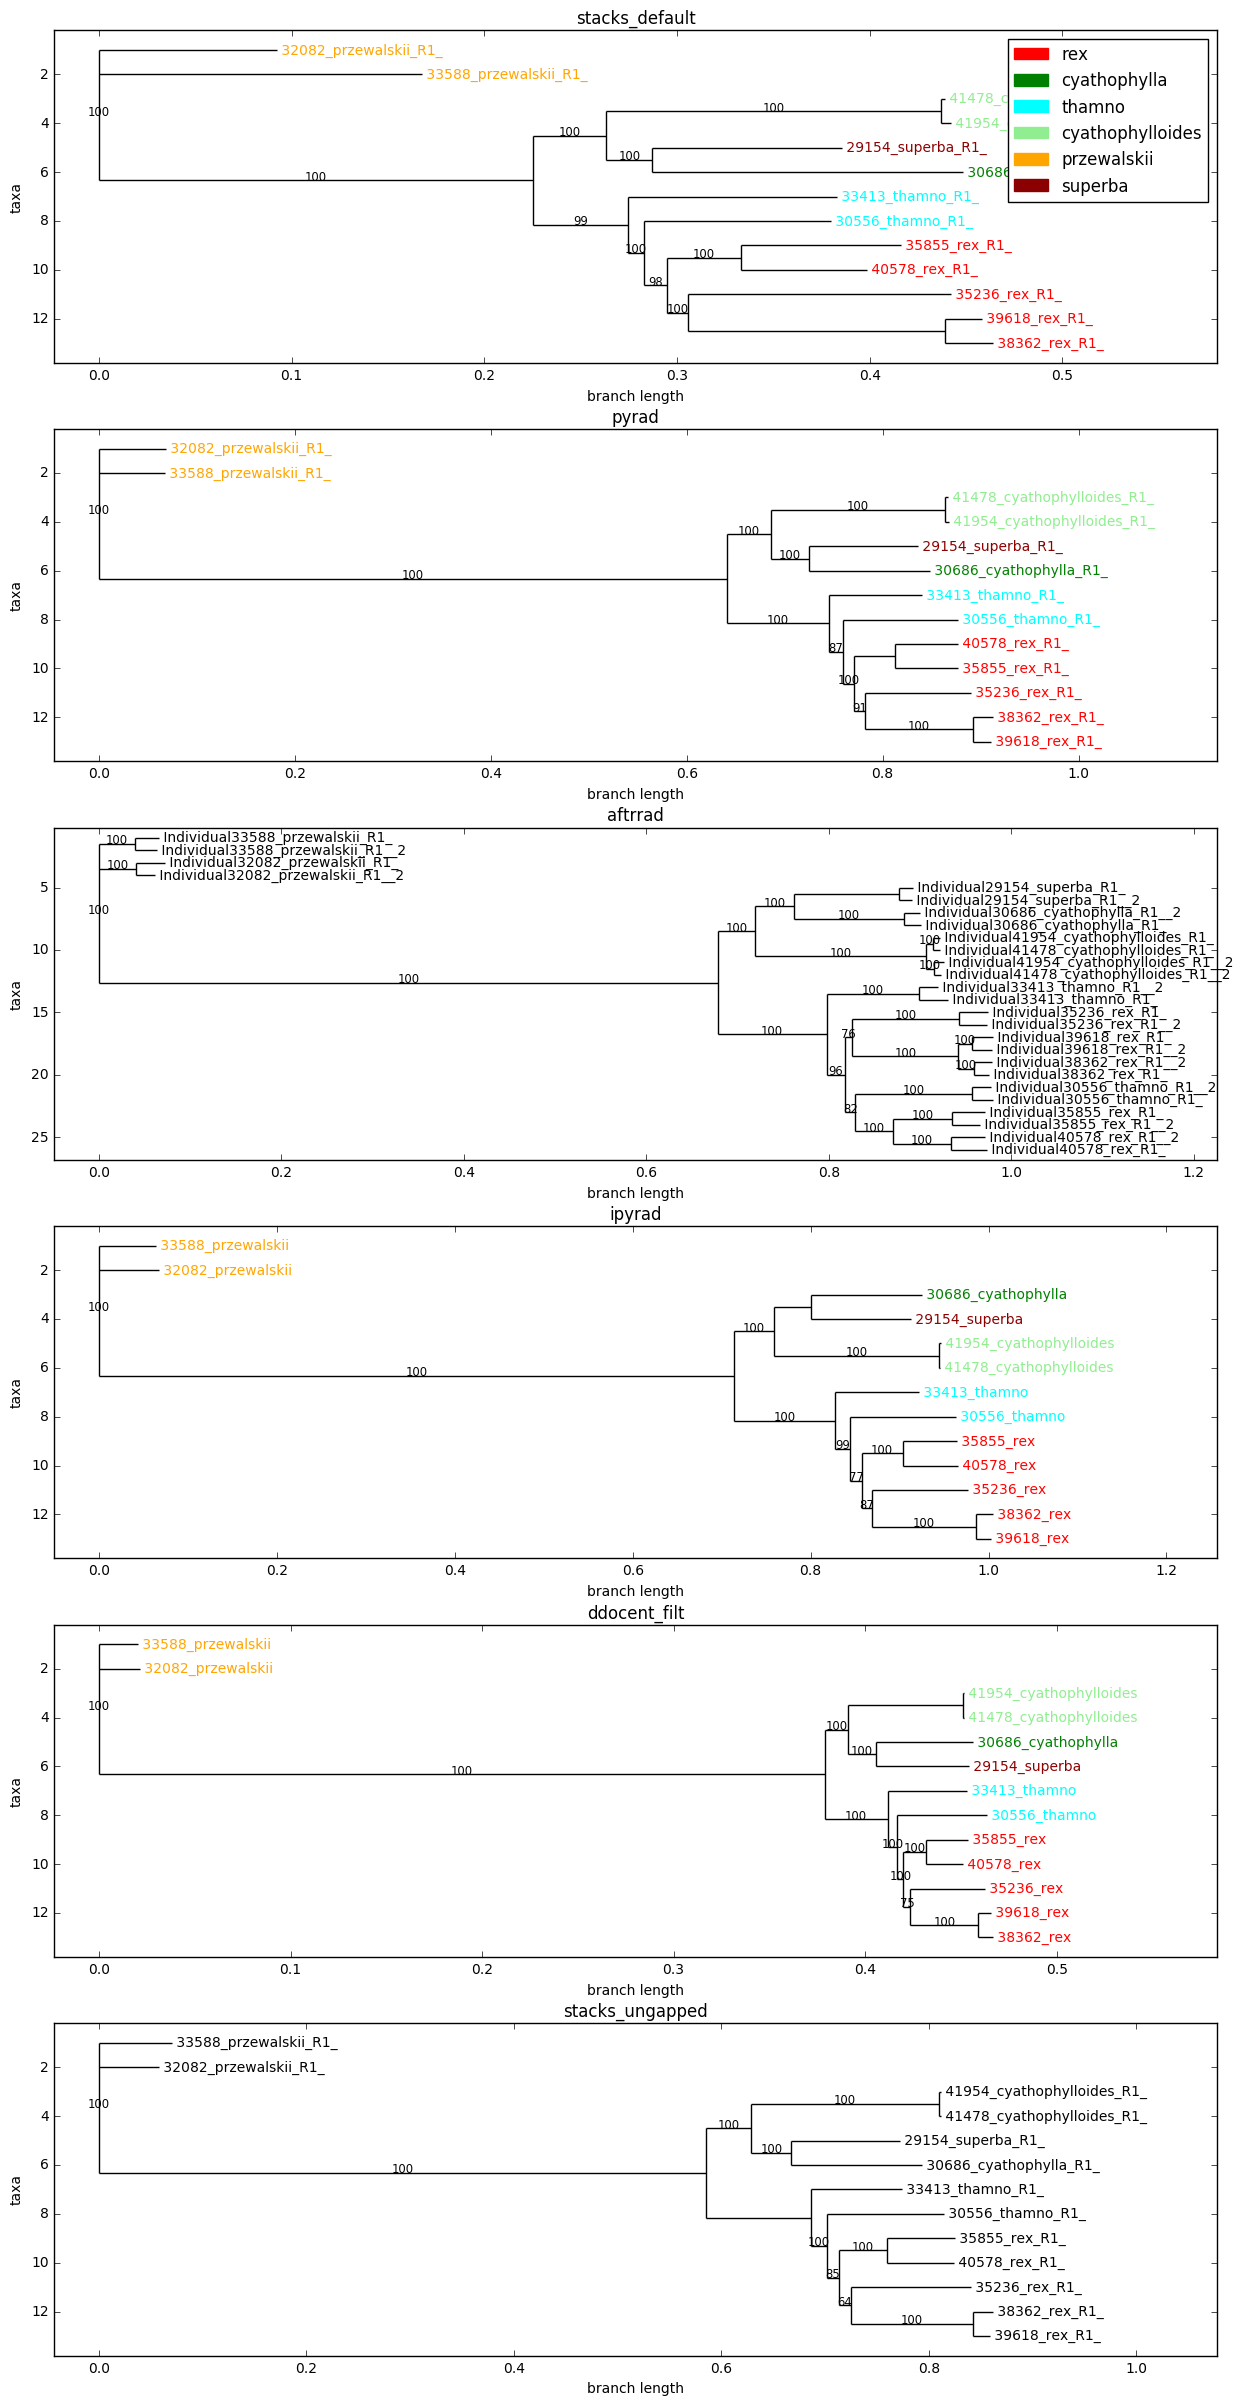

In [128]:
treefiles = ped_trees

legend_colors = [matplotlib.patches.Patch(color=v, label=k) for k,v in species_colors.items()]

## Root the tree on the WBS pop
outgroup = [{'name': sample_name} for sample_name in samples_per_species["przewalskii"]]

f, axarr = plt.subplots(6, 1, figsize=(15, 30), dpi=1000)
#axarr = [a for b in axarr for a in b]

for name, ax in zip(treefiles.keys(), axarr):
    print(name, ax)
    try:
        tree = Phylo.read(treefiles[name], 'newick')
        
        outgroup = [{"name":x.name} for x in tree.get_terminals() if "prze" in x.name]
        if "ddocent" in name or "ipyrad" in name:
#            outgroup = [{g.keys():g.values().split("_R1_")[0] for g in outgroup}]
            emp_colors_per_sample = {k.split("_R1_")[0]:v for k,v in emp_colors_per_sample.items()}
        
        tree.root_with_outgroup(*outgroup)
        tree.ladderize()
        ## This could be cool but doesn't work
        Phylo.draw(tree, axes=ax, label_colors=emp_colors_per_sample, do_show=False)
        ax.set_title(name)
    except Exception as inst:
        print("failed - {}".format(name))
        print(inst)
axarr[0].legend(handles=legend_colors)

In [125]:
pzew = [{"name":x.name} for x in tree.get_terminals() if "prze" in x.name]
print(pzew)

[{'name': '33588_przewalskii_R1_'}, {'name': '32082_przewalskii_R1_'}]
